In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 31 11:42:46 2024

@author: venkatesh
"""

import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import numpy as np

/home/venkatesh/anaconda3/envs/venkatesh_pytorch_updated_110/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
model_name='mobilenetv2'

num_classes = 4
# Assuming 3 classes: "NORMAL", "DRUSEN", "DME","CNV"

if(model_name=='mobilenetv2'):
    from models.mobilenet import MobileNet2
    model=MobileNet2(in_channels=1, num_classes=4)
if(model_name=='ResNet50'):
    from models.resnet import ResNet50
    model=ResNet50(num_classes=num_classes, channels=3)    
if(model_name=='ShuffleNet2'):
    from models.ShuffleNet2 import ShuffleNet2
    model=ShuffleNet2(num_classes=num_classes)    
if(model_name=='SqueezeNet'):
    from models.SqueezeNet import SqueezeNet
    model=SqueezeNet(num_classes=num_classes)

torch.Size([1, 4])


In [4]:
model=model.to(device)


In [5]:
from datetime import datetime
import time

import os
print ('*******************************************************')
start_time=time.time()
experiments_folder="saved_models/"
experiment_name=datetime.now().strftime("%b_%d_%I_%M_%P_")+"_model_"+model_name

directory=experiments_folder+"/"+experiment_name+"/"
print(directory)
print('Model will be saved to  :', directory)

try:
    os.makedirs(directory)
except:
    print('model already existed..........')

*******************************************************
saved_models//Jul_31_12_46_pm__model_mobilenetv2/
Model will be saved to  : saved_models//Jul_31_12_46_pm__model_mobilenetv2/


In [6]:
import torchvision.transforms as transforms

# Define transformations for data augmentation or normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to required size
    transforms.ToTensor()
])

In [30]:
from dataset import CustomDataset
from torch.utils.data import Dataset, DataLoader

# Create CustomDataset instance
dataset = CustomDataset('./csv_files/data_train.csv', transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

val_dataset = CustomDataset('./csv_files/data_valid.csv', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(train_loader))
print(len(val_dataloader))

print('number of testing images',len(test_dataset))


2166
271
number of testing images 86648


In [8]:


learning_rate=0.0001
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Train your model
# Train your model
from tqdm import tqdm

# Define your training function
model.train()
train_losses = []  # List to store training losses
val_losses = []  # List to store validaion losses
train_accuracy=[]
validation_accuracy=[]

num_epochs=25



for epoch in range(num_epochs):
    running_loss = 0.0
    validation_loss=0.0
    
    y_true_train = []
    y_pred_train = []


    # Create tqdm progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        #print(torch.unique(images))
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        y_pred_train.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())

        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Loss': running_loss / (batch_idx + 1)})

        
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    train_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, running_loss))
    print("Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")
        
    save_path=directory+'/mymodel_'+str(epoch)+'.pth'
    torch.save(model.state_dict(), save_path)
    print(f'Model saved at: {save_path}')

    # storing the train losses
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    progress_bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}')

    y_true_val = []
    y_pred_val = []

    
    model.eval()
    for batch_idx, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        #images=images/255
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        validation_loss += loss.item()

        y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
        y_true_val.extend(labels.detach().tolist())

        
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'Validation Loss': validation_loss / (batch_idx + 1)})

    # storing the validation losses

    epoch_loss = validation_loss / len(val_dataloader)
    val_losses.append(epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
    total = len(y_true_val)
    accuracy = total_correct * 100 / total
    validation_accuracy.append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Val mean loss: {:.8f}".format(epoch, validation_loss))
    print("valiation Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

    import pandas as pd

    loss_dic={"training_loss":train_losses,
              "val_loss":val_losses,
              "train_accuracy":train_accuracy,
              "validation_accuracy":validation_accuracy}

    df = pd.DataFrame.from_dict(loss_dic) 
    path=directory+'/loss.csv'
    df.to_csv (path, index = False, header=True)

Epoch 1/25: 100%|██████████| 2166/2166 [01:40<00:00, 21.62it/s, Loss=0.762]


-------------------------------------------------
Epoch: 0 Train mean loss: 1650.60255197
Train Accuracy%:  74.01892890120037 == 12826 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_0.pth
Epoch [1/25], Loss: 0.7621


Epoch 1/25: 100%|██████████| 271/271 [00:08<00:00, 32.36it/s, Validation Loss=0.588]


Epoch [1/25], Loss: 0.5877
-------------------------------------------------
Epoch: 0 Val mean loss: 159.27813441
valiation Accuracy%:  78.58790955237656 == 1703 / 2167
-------------------------------------------------


Epoch 2/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.24it/s, Loss=0.592]


-------------------------------------------------
Epoch: 1 Train mean loss: 1282.48682651
Train Accuracy%:  79.84764542936288 == 13836 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_1.pth
Epoch [2/25], Loss: 0.5921


Epoch 2/25: 100%|██████████| 271/271 [00:08<00:00, 32.62it/s, Validation Loss=0.542]


Epoch [2/25], Loss: 0.5420
-------------------------------------------------
Epoch: 1 Val mean loss: 146.88582198
valiation Accuracy%:  80.75680664513152 == 1750 / 2167
-------------------------------------------------


Epoch 3/25: 100%|██████████| 2166/2166 [01:38<00:00, 21.89it/s, Loss=0.475]


-------------------------------------------------
Epoch: 2 Train mean loss: 1028.14525584
Train Accuracy%:  84.29709141274238 == 14607 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_2.pth
Epoch [3/25], Loss: 0.4747


Epoch 3/25: 100%|██████████| 271/271 [00:08<00:00, 32.34it/s, Validation Loss=0.411]


Epoch [3/25], Loss: 0.4115
-------------------------------------------------
Epoch: 2 Val mean loss: 111.50625286
valiation Accuracy%:  86.06368251038302 == 1865 / 2167
-------------------------------------------------


Epoch 4/25: 100%|██████████| 2166/2166 [01:38<00:00, 21.93it/s, Loss=0.389]


-------------------------------------------------
Epoch: 3 Train mean loss: 842.46976257
Train Accuracy%:  87.06140350877193 == 15086 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_3.pth
Epoch [4/25], Loss: 0.3890


Epoch 4/25: 100%|██████████| 271/271 [00:08<00:00, 33.07it/s, Validation Loss=0.359]


Epoch [4/25], Loss: 0.3594
-------------------------------------------------
Epoch: 3 Val mean loss: 97.39139538
valiation Accuracy%:  88.41716658975542 == 1916 / 2167
-------------------------------------------------


Epoch 5/25: 100%|██████████| 2166/2166 [01:38<00:00, 22.00it/s, Loss=0.334]


-------------------------------------------------
Epoch: 4 Train mean loss: 722.69690692
Train Accuracy%:  88.97737765466297 == 15418 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_4.pth
Epoch [5/25], Loss: 0.3337


Epoch 5/25: 100%|██████████| 271/271 [00:08<00:00, 33.42it/s, Validation Loss=0.324]


Epoch [5/25], Loss: 0.3244
-------------------------------------------------
Epoch: 4 Val mean loss: 87.91480493
valiation Accuracy%:  89.20166128287956 == 1933 / 2167
-------------------------------------------------


Epoch 6/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.31it/s, Loss=0.287]


-------------------------------------------------
Epoch: 5 Train mean loss: 621.05210594
Train Accuracy%:  90.4028162511542 == 15665 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_5.pth
Epoch [6/25], Loss: 0.2867


Epoch 6/25: 100%|██████████| 271/271 [00:08<00:00, 33.82it/s, Validation Loss=0.277]


Epoch [6/25], Loss: 0.2769
-------------------------------------------------
Epoch: 5 Val mean loss: 75.03664769
valiation Accuracy%:  90.63221042916474 == 1964 / 2167
-------------------------------------------------


Epoch 7/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.30it/s, Loss=0.253]


-------------------------------------------------
Epoch: 6 Train mean loss: 548.95901766
Train Accuracy%:  91.58587257617728 == 15870 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_6.pth
Epoch [7/25], Loss: 0.2534


Epoch 7/25: 100%|██████████| 271/271 [00:08<00:00, 33.39it/s, Validation Loss=0.293]


Epoch [7/25], Loss: 0.2926
-------------------------------------------------
Epoch: 6 Val mean loss: 79.29695109
valiation Accuracy%:  90.72450392247346 == 1966 / 2167
-------------------------------------------------


Epoch 8/25: 100%|██████████| 2166/2166 [01:40<00:00, 21.64it/s, Loss=0.227]


-------------------------------------------------
Epoch: 7 Train mean loss: 492.44264503
Train Accuracy%:  92.53231763619576 == 16034 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_7.pth
Epoch [8/25], Loss: 0.2274


Epoch 8/25: 100%|██████████| 271/271 [00:08<00:00, 32.49it/s, Validation Loss=0.263]


Epoch [8/25], Loss: 0.2633
-------------------------------------------------
Epoch: 7 Val mean loss: 71.34705022
valiation Accuracy%:  91.18597138901707 == 1976 / 2167
-------------------------------------------------


Epoch 9/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.30it/s, Loss=0.203]


-------------------------------------------------
Epoch: 8 Train mean loss: 439.46203306
Train Accuracy%:  93.12673130193906 == 16137 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_8.pth
Epoch [9/25], Loss: 0.2029


Epoch 9/25: 100%|██████████| 271/271 [00:08<00:00, 33.09it/s, Validation Loss=0.266]


Epoch [9/25], Loss: 0.2664
-------------------------------------------------
Epoch: 8 Val mean loss: 72.19042284
valiation Accuracy%:  91.64743885556068 == 1986 / 2167
-------------------------------------------------


Epoch 10/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.16it/s, Loss=0.187]


-------------------------------------------------
Epoch: 9 Train mean loss: 405.06345178
Train Accuracy%:  93.88850415512465 == 16269 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_9.pth
Epoch [10/25], Loss: 0.1870


Epoch 10/25: 100%|██████████| 271/271 [00:08<00:00, 32.79it/s, Validation Loss=0.265]


Epoch [10/25], Loss: 0.2651
-------------------------------------------------
Epoch: 9 Val mean loss: 71.85117493
valiation Accuracy%:  91.87817258883248 == 1991 / 2167
-------------------------------------------------


Epoch 11/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.27it/s, Loss=0.174]


-------------------------------------------------
Epoch: 10 Train mean loss: 376.04127830
Train Accuracy%:  94.2578485687904 == 16333 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_10.pth
Epoch [11/25], Loss: 0.1736


Epoch 11/25: 100%|██████████| 271/271 [00:08<00:00, 32.70it/s, Validation Loss=0.277]


Epoch [11/25], Loss: 0.2769
-------------------------------------------------
Epoch: 10 Val mean loss: 75.03990735
valiation Accuracy%:  91.32441162898016 == 1979 / 2167
-------------------------------------------------


Epoch 12/25: 100%|██████████| 2166/2166 [01:36<00:00, 22.39it/s, Loss=0.164]


-------------------------------------------------
Epoch: 11 Train mean loss: 355.60179231
Train Accuracy%:  94.62719298245614 == 16397 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_11.pth
Epoch [12/25], Loss: 0.1642


Epoch 12/25: 100%|██████████| 271/271 [00:08<00:00, 33.59it/s, Validation Loss=0.242]


Epoch [12/25], Loss: 0.2420
-------------------------------------------------
Epoch: 11 Val mean loss: 65.58193743
valiation Accuracy%:  92.52422704199354 == 2005 / 2167
-------------------------------------------------


Epoch 13/25: 100%|██████████| 2166/2166 [01:39<00:00, 21.87it/s, Loss=0.153]


-------------------------------------------------
Epoch: 12 Train mean loss: 331.72768233
Train Accuracy%:  94.94459833795014 == 16452 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_12.pth
Epoch [13/25], Loss: 0.1532


Epoch 13/25: 100%|██████████| 271/271 [00:08<00:00, 32.50it/s, Validation Loss=0.232]


Epoch [13/25], Loss: 0.2324
-------------------------------------------------
Epoch: 12 Val mean loss: 62.99294471
valiation Accuracy%:  92.66266728195662 == 2008 / 2167
-------------------------------------------------


Epoch 14/25: 100%|██████████| 2166/2166 [01:40<00:00, 21.65it/s, Loss=0.153]


-------------------------------------------------
Epoch: 13 Train mean loss: 332.31467062
Train Accuracy%:  94.88111726685133 == 16441 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_13.pth
Epoch [14/25], Loss: 0.1534


Epoch 14/25: 100%|██████████| 271/271 [00:08<00:00, 32.36it/s, Validation Loss=0.265]


Epoch [14/25], Loss: 0.2650
-------------------------------------------------
Epoch: 13 Val mean loss: 71.82355852
valiation Accuracy%:  92.01661282879557 == 1994 / 2167
-------------------------------------------------


Epoch 15/25: 100%|██████████| 2166/2166 [01:40<00:00, 21.61it/s, Loss=0.151]


-------------------------------------------------
Epoch: 14 Train mean loss: 327.93353653
Train Accuracy%:  95.03693444136657 == 16468 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_14.pth
Epoch [15/25], Loss: 0.1514


Epoch 15/25: 100%|██████████| 271/271 [00:08<00:00, 32.61it/s, Validation Loss=0.224]


Epoch [15/25], Loss: 0.2241
-------------------------------------------------
Epoch: 14 Val mean loss: 60.72500316
valiation Accuracy%:  93.30872173511767 == 2022 / 2167
-------------------------------------------------


Epoch 16/25: 100%|██████████| 2166/2166 [01:39<00:00, 21.87it/s, Loss=0.145]


-------------------------------------------------
Epoch: 15 Train mean loss: 314.68487970
Train Accuracy%:  95.11772853185596 == 16482 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_15.pth
Epoch [16/25], Loss: 0.1453


Epoch 16/25: 100%|██████████| 271/271 [00:08<00:00, 32.28it/s, Validation Loss=0.244]


Epoch [16/25], Loss: 0.2442
-------------------------------------------------
Epoch: 15 Val mean loss: 66.17327359
valiation Accuracy%:  92.10890632210429 == 1996 / 2167
-------------------------------------------------


Epoch 17/25: 100%|██████████| 2166/2166 [01:38<00:00, 22.04it/s, Loss=0.132]


-------------------------------------------------
Epoch: 16 Train mean loss: 285.45147465
Train Accuracy%:  95.64289012003694 == 16573 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_16.pth
Epoch [17/25], Loss: 0.1318


Epoch 17/25: 100%|██████████| 271/271 [00:08<00:00, 32.87it/s, Validation Loss=0.256]


Epoch [17/25], Loss: 0.2556
-------------------------------------------------
Epoch: 16 Val mean loss: 69.26194398
valiation Accuracy%:  92.70881402861099 == 2009 / 2167
-------------------------------------------------


Epoch 18/25: 100%|██████████| 2166/2166 [01:38<00:00, 22.09it/s, Loss=0.126]


-------------------------------------------------
Epoch: 17 Train mean loss: 272.32437598
Train Accuracy%:  95.82756232686981 == 16605 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_17.pth
Epoch [18/25], Loss: 0.1257


Epoch 18/25: 100%|██████████| 271/271 [00:08<00:00, 33.36it/s, Validation Loss=0.252]


Epoch [18/25], Loss: 0.2523
-------------------------------------------------
Epoch: 17 Val mean loss: 68.37327265
valiation Accuracy%:  92.75496077526535 == 2010 / 2167
-------------------------------------------------


Epoch 19/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.19it/s, Loss=0.119]


-------------------------------------------------
Epoch: 18 Train mean loss: 257.70407627
Train Accuracy%:  96.17382271468144 == 16665 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_18.pth
Epoch [19/25], Loss: 0.1190


Epoch 19/25: 100%|██████████| 271/271 [00:08<00:00, 32.86it/s, Validation Loss=0.274]


Epoch [19/25], Loss: 0.2742
-------------------------------------------------
Epoch: 18 Val mean loss: 74.30139411
valiation Accuracy%:  92.52422704199354 == 2005 / 2167
-------------------------------------------------


Epoch 20/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.19it/s, Loss=0.128]


-------------------------------------------------
Epoch: 19 Train mean loss: 278.20916511
Train Accuracy%:  95.70637119113573 == 16584 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_19.pth
Epoch [20/25], Loss: 0.1284


Epoch 20/25: 100%|██████████| 271/271 [00:08<00:00, 33.04it/s, Validation Loss=0.236]


Epoch [20/25], Loss: 0.2360
-------------------------------------------------
Epoch: 19 Val mean loss: 63.94605074
valiation Accuracy%:  93.26257498846331 == 2021 / 2167
-------------------------------------------------


Epoch 21/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.25it/s, Loss=0.125]


-------------------------------------------------
Epoch: 20 Train mean loss: 270.05472967
Train Accuracy%:  95.83333333333333 == 16606 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_20.pth
Epoch [21/25], Loss: 0.1247


Epoch 21/25: 100%|██████████| 271/271 [00:08<00:00, 33.22it/s, Validation Loss=0.24] 


Epoch [21/25], Loss: 0.2398
-------------------------------------------------
Epoch: 20 Val mean loss: 64.97247225
valiation Accuracy%:  93.72404245500692 == 2031 / 2167
-------------------------------------------------


Epoch 22/25: 100%|██████████| 2166/2166 [01:36<00:00, 22.42it/s, Loss=0.123]


-------------------------------------------------
Epoch: 21 Train mean loss: 265.93986566
Train Accuracy%:  95.95452446906741 == 16627 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_21.pth
Epoch [22/25], Loss: 0.1228


Epoch 22/25: 100%|██████████| 271/271 [00:08<00:00, 32.67it/s, Validation Loss=0.275]


Epoch [22/25], Loss: 0.2745
-------------------------------------------------
Epoch: 21 Val mean loss: 74.39410265
valiation Accuracy%:  92.89340101522842 == 2013 / 2167
-------------------------------------------------


Epoch 23/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.22it/s, Loss=0.113]


-------------------------------------------------
Epoch: 22 Train mean loss: 244.15894599
Train Accuracy%:  96.30655586334257 == 16688 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_22.pth
Epoch [23/25], Loss: 0.1127


Epoch 23/25: 100%|██████████| 271/271 [00:08<00:00, 33.23it/s, Validation Loss=0.234]


Epoch [23/25], Loss: 0.2337
-------------------------------------------------
Epoch: 22 Val mean loss: 63.33449902
valiation Accuracy%:  93.21642824180896 == 2020 / 2167
-------------------------------------------------


Epoch 24/25: 100%|██████████| 2166/2166 [01:38<00:00, 21.98it/s, Loss=0.115]


-------------------------------------------------
Epoch: 23 Train mean loss: 249.09726040
Train Accuracy%:  96.1218836565097 == 16656 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_23.pth
Epoch [24/25], Loss: 0.1150


Epoch 24/25: 100%|██████████| 271/271 [00:08<00:00, 33.61it/s, Validation Loss=0.253]


Epoch [24/25], Loss: 0.2533
-------------------------------------------------
Epoch: 23 Val mean loss: 68.64230986
valiation Accuracy%:  93.07798800184587 == 2017 / 2167
-------------------------------------------------


Epoch 25/25: 100%|██████████| 2166/2166 [01:37<00:00, 22.24it/s, Loss=0.117]


-------------------------------------------------
Epoch: 24 Train mean loss: 254.36017660
Train Accuracy%:  96.1218836565097 == 16656 / 17328
-------------------------------------------------
Model saved at: saved_models//Jul_31_12_46_pm__model_mobilenetv2//mymodel_24.pth
Epoch [25/25], Loss: 0.1174


Epoch 25/25: 100%|██████████| 271/271 [00:08<00:00, 32.80it/s, Validation Loss=0.284]

Epoch [25/25], Loss: 0.2842
-------------------------------------------------
Epoch: 24 Val mean loss: 77.01614095
valiation Accuracy%:  92.24734656206738 == 1999 / 2167
-------------------------------------------------


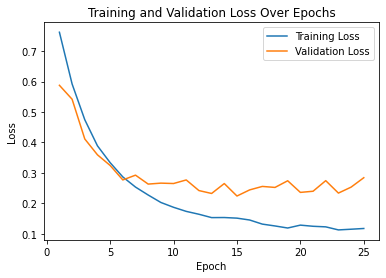

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Model Analysis

In [12]:
from torchsummary import summary

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             288
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           1,024
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]             288
       BatchNorm2d-8         [-1, 32, 112, 112]              64
             ReLU6-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]             512
      BatchNorm2d-11         [-1, 16, 112, 112]              32
 LinearBottleneck-12         [-1, 16, 112, 112]               0
           Conv2d-13         [-1, 96, 112, 112]           1,536
      BatchNorm2d-14         [-1, 96, 1

In [13]:
import re
from ptflops import get_model_complexity_info
from pthflops import count_ops

macs, params = get_model_complexity_info(model, (1, 224,224), as_strings=True,print_per_layer_stat=False, verbose=False)
# # Extract the numerical value
flops = eval(re.findall(r'([\d.]+)', macs)[0])*2
# Extract the unit
flops_unit = re.findall(r'([A-Za-z]+)', macs)[0][0]

print('Computational complexity: {:<8}'.format(macs))
print('Computational complexity: {} {}Flops'.format(flops, flops_unit))
print('Number of parameters: {:<8}'.format(params))

Computational complexity: 325.91 MMac
Computational complexity: 651.82 MFlops
Number of parameters: 2.23 M  


# Testing 

In [22]:
# choosing the best model from validation loss.

best_epoch=np.argmin(val_losses)
print('best_epoch:',best_epoch)

best_epoch: 14


In [23]:
ckpt = torch.load(directory+'/mymodel_'+str(best_epoch)+'.pth')
model.load_state_dict(ckpt)
model.eval()


MobileNet2(
  (activation): ReLU6(inplace=True)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottlenecks): Sequential(
    (Bottlenecks_0): Sequential(
      (LinearBottleneck0_0): LinearBottleneck(
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU6(inplace=True)
      )
    )
    (Bottlenecks_1): Sequential(
      (LinearBottleneck1_0):

In [28]:
test_dataset = CustomDataset('./csv_files/test_on_remaining_data.csv', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(len(test_dataloader))


10831


In [29]:
from tqdm import tqdm

progress_bar = tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f'testing')

y_true_val = []
y_pred_val = []


model.eval()
for batch_idx, (images, labels) in progress_bar:
    images = images.to(device)
    labels = labels.to(device)
    #images=images/255
    optimizer.zero_grad()

    outputs = model(images)

    y_pred_val.extend(outputs.detach().argmax(dim=-1).tolist())
    y_true_val.extend(labels.detach().tolist())



    # Update progress bar description with current loss



total_correct = len([True for x, y in zip(y_pred_val, y_true_val) if x==y])
total = len(y_true_val)
accuracy = total_correct * 100 / total

print("-------------------------------------------------")
print("TEST Accuracy (%): ", accuracy, "==", total_correct, "/", total)
print("-------------------------------------------------")


testing: 100%|██████████| 10831/10831 [05:21<00:00, 33.72it/s]

-------------------------------------------------
TEST Accuracy (%):  92.1729295540578 == 79866 / 86648
-------------------------------------------------


# Demo on Test data

[0, 3, 3, 0, 0, 0, 2, 3]
tensor([0, 3, 3, 0, 0, 0, 2, 1])


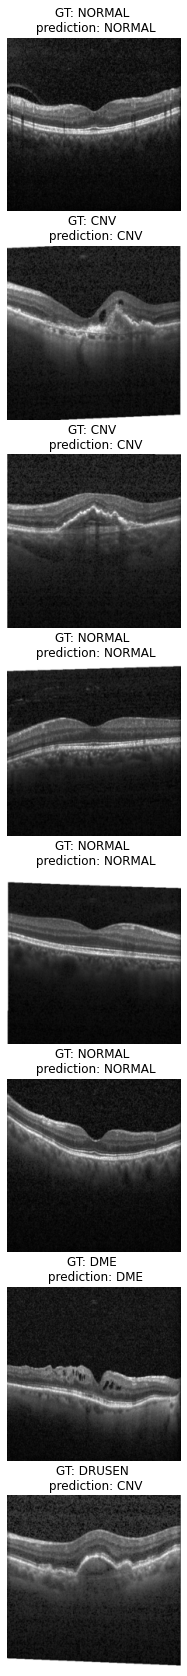

In [35]:
import matplotlib.pyplot as plt

int_to_class = {0:"NORMAL" , 1:"DRUSEN", 2:"DME" ,3:"CNV"}  
# Function to show images
def show_images(images, labels,predictions):
    plt.figure(figsize=(30, 30))
    for i in range(len(images)):
        plt.subplot(len(images),1 , i + 1)
        plt.title(f"GT: {int_to_class[labels[i].item()]} \n prediction: {int_to_class[predictions[i]]}")
        plt.imshow(images[i][0], cmap="gray")
        plt.axis('off')
    plt.show()

# Display a batch of images
for images, labels in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    outputs_cpu=outputs.detach().argmax(dim=-1).tolist()
    print(outputs_cpu)
    print(labels)
    
    break  # Show only the first batch
    
    
images=images.to('cpu')
    
show_images(images,labels,outputs_cpu)